# Random Forest-Based Event Classification Workflow

This notebook demonstrates a complete workflow for classifying change events using a Random Forest (RF) model. The process involves loading labelled and unlabelled data, training a model, and applying it to classify unlabelled events. The results are saved and projected into a GIS-compatible format for further analysis.

## Workflow
1. **Setup**: Import necessary modules and set the working directory.
2. **Configuration**: Define input/output file paths, hyperparameters, and other constants.
3. **Model Training**: Train a Random Forest model on labelled change events using grid search for hyperparameter tuning.
4. **Model Persistence**: Save the trained model to disk and demonstrate reloading it.
5. **Classification**: Apply the trained model to classify unlabelled change events and save the predictions.
6. **GIS Projection**: Convert the classified events into a GeoJSON format for GIS visualization.

## Outputs
- `change_events_labelled_using_random_forest.json`: Classified change events with predicted labels.
- `best_model.joblib`: Trained Random Forest model.
- GeoJSON files: GIS-compatible projections of classified events.

This notebook provides a structured approach to event classification and GIS integration, ensuring reproducibility and scalability.

## Imports & Working Directory
In order to ensure all imports are available and that paths are relative to this script’s location, we first import modules and set the working directory.

In [1]:
from aimon import ProjectChange
from aimon import ChangeEventCollection
from aimon import utilities
import os
import git
# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

## Define Paths & Hyperparameters
To keep configuration in one place, we declare input/output file paths, the RF hyperparameter grid, and other constants.

In [2]:
# Input files and output folder
labelled_file    = "../test_data/change_events_labelled.json"
unlabelled_file  = "../test_data/change_events_unlabelled.json"
outfolder        = "../test_data/out"
os.makedirs(outfolder, exist_ok=True)

# Train/test split
test_size       = 0.2
random_state    = 3

param_grid = {
    'n_estimators':       [50, 100, 200],
    'max_depth':          [None, 5, 10, 20, 30],
    'min_samples_split':  [2, 5, 10],
    'min_samples_leaf':   [1, 2, 4],
    'max_features':       ['sqrt', 'log2', None],
    'bootstrap':          [True]
}

# Labels to ignore during training
ignore_labels = ["undefined"]

# Paths for outputs
predicted_file = os.path.join(outfolder, "change_events_labelled_using_random_forest.json")
model_file     = os.path.join(outfolder, "best_model.joblib")


## Train Random Forest on Labelled Data
In order to build a model for event classification, we load the labelled events and run a grid‑search RF.

Best params: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Train  F1: 0.9907858772167454
Test   F1: 0.8020458003042678

Classification Report:
                           precision    recall  f1-score   support

gravitationalMassMovement       0.84      0.82      0.83       366
               vegetation       0.76      0.79      0.78       272

                 accuracy                           0.81       638
                macro avg       0.80      0.80      0.80       638
             weighted avg       0.81      0.81      0.81       638



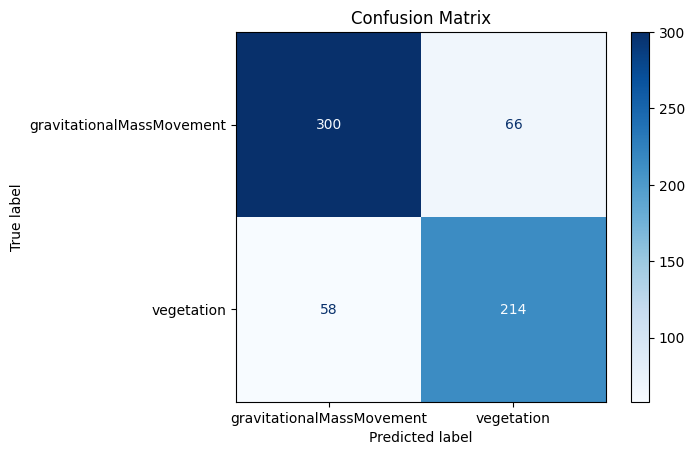

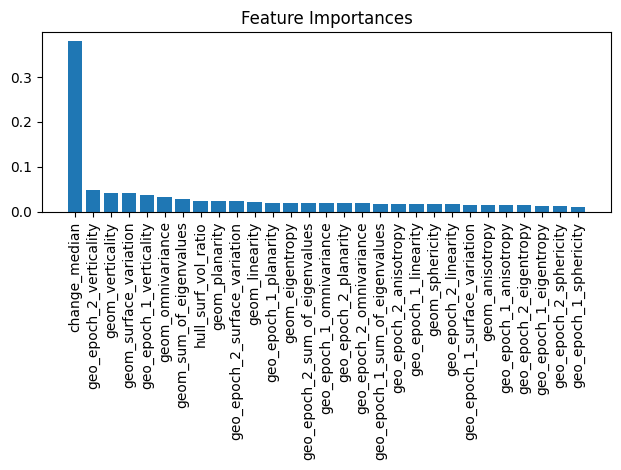

Jaccard Score:                  0.670
Accuracy Score:                 0.806
F1 Score (macro):               0.802
Matthews Corr. Coef.:           0.604
Cohen's Kappa:                  0.604


In [3]:
# Load labelled events collection
coll = ChangeEventCollection.load_from_file(labelled_file)

# Train RF with grid search, holding out a test split
coll.train_random_forest(
    ignore_labels=ignore_labels,
    param_grid=param_grid,
    test_size=test_size,
    random_state=random_state
)


## Save & Reload the Trained Model
To keep our best model for later reuse, we save it to disk, then demonstrate loading it back.

In [4]:
# Persist the trained model
coll.save_model(model_file)

# (Later or elsewhere) reload it
coll.load_model(model_file)

Model saved to ../test_data/out/best_model.joblib
Model loaded from ../test_data/out/best_model.joblib


## Classify Unlabelled Events & Save
With a trained RF loaded into memory, we apply it to previously unlabelled events and write out the new labels.

In [5]:
# Load unlabelled events, attach trained model, and classify
unlabelled_coll = ChangeEventCollection.load_from_file(unlabelled_file)
unlabelled_coll.model = coll.model
unlabelled_coll.apply_random_forest()

# Save predictions to JSON
unlabelled_coll.save_to_file(predicted_file)

## Project Changes into GIS Format
Finally, we wrap up by projecting our labelled events into GeoJSON using ProjectChange.

In [3]:
git_repo = git.Repo(current_dir, search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

img_path = os.path.join(git_root, "test_data/RangeImage.tif")
change_prj = ProjectChange(
    change_event_file       = predicted_file,
    project_name            = os.path.basename(predicted_file)[:-5],
    projected_image_path    = img_path,
    projected_events_folder = outfolder,
    epsg                    = 31254
)

change_prj.project_change()

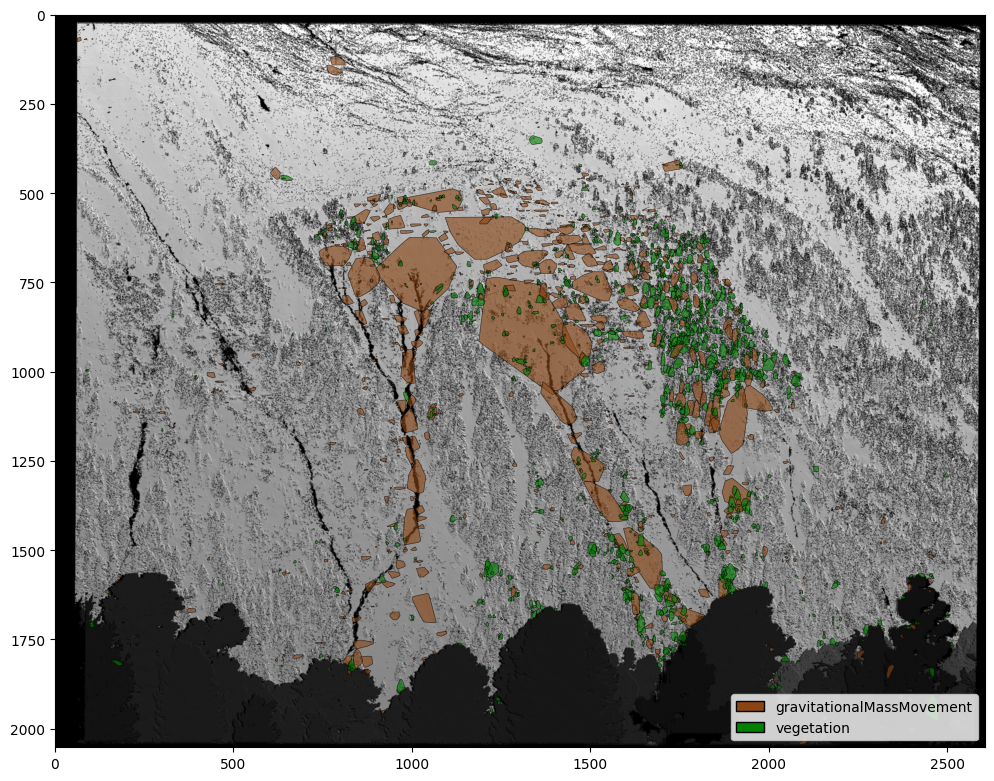

In [ ]:
# Paths to the vector and raster files
vector = "../test_data/out/change_events_labelled_using_random_forest_change_events_pixel.geojson"
raster = "../test_data/RangeImage.tif"

utilities.plot_change_events(vector, raster, 'event_type', ['#8B4513', 'green'])